+ ### Generate VAE encodings for hourly data

In [76]:
from trainer_VAE import VAETrainer
import matplotlib.pyplot as plt
import pandas as pd, numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler


def encode_hourly_data(latent_dim=64, num_hidden_layers=2):
    model_dir = f'./final2_vae_model/latent_dim_{latent_dim}_layers_{num_hidden_layers}/'
    # model_dir = f'./vae_model_origine/latent_dim_{latent_dim}_layers_{num_hidden_layers}/'
    model_file_pref = f'model_'
    vae = VAETrainer.load_model(model_dir, model_file_pref)
    vae.summary()

    scaler = StandardScaler()
    # train_data = np.load('./datasets/hourly_train.npy')
    train_data = np.load('./final2/train.npy')
    scaler.fit(train_data)
    

    data = scaler.transform(train_data)
    n_data = len(data) // 24-1 
    encode = np.zeros((24, n_data, vae.latent_dim))
    for i in range(0, len(data) - 24 - 1):
        day_data = data[i:i+24]
        encode[i % 24][i // 24] = vae.encode(day_data)
    print('data shape : ', data.shape)
    print('encoded shape : ', encode.shape)
    np.save('./final2/encoded_train.npy', encode)

    # test_data = np.load('./datasets/hourly_test.npy')
    test_data = np.load('./final2/test.npy')
    data = scaler.transform(test_data)
    
    n_data = len(data) // 24
    encode = np.zeros((n_data, vae.latent_dim))
    for i in range(0, len(data), 24):
        day_data = data[i:i+24]
        encode[i//24] = vae.encode(day_data)
    print('data shape : ', data.shape)
    print('encoded shape : ', encode.shape)
    np.save('./final2/encoded_test.npy', encode)

encode_hourly_data(latent_dim=64, num_hidden_layers=2)


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 24, 5)]      0                                            
__________________________________________________________________________________________________
enc_conv_0 (Conv1D)             (None, 12, 512)      8192        encoder_input[0][0]              
__________________________________________________________________________________________________
enc_conv_1 (Conv1D)             (None, 6, 512)       786944      enc_conv_0[0][0]                 
__________________________________________________________________________________________________
enc_flatten (Flatten)           (None, 3072)         0           enc_conv_1[0][0]                 
____________________________________________________________________________________________

+ ### Compare VAE-only reconstructed hourly data with original

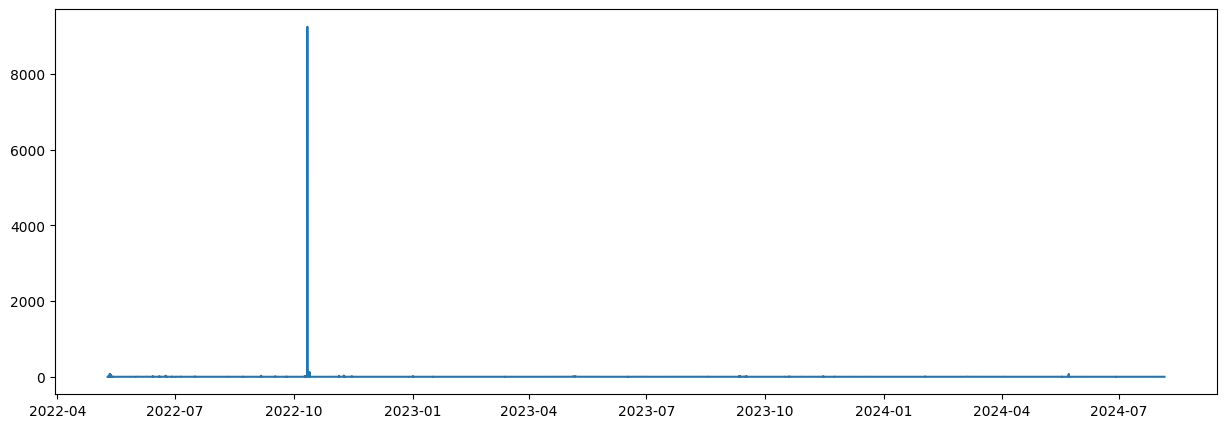

In [79]:
# orig = np.load('./datasets/hourly_test.npy')
# encoded = np.load('./final2/encoded_test.npy')
orig = np.load('./final2/test.npy')

encoded = np.load('./final2/encoded_test.npy')


data = pd.read_csv('./final2/data.csv')
data['Hour'] = pd.to_datetime(data['Hour'])

# 获取时间列作为索引
x = data['Hour'].dt.to_pydatetime().tolist()
x = x[6648:6648+5880]

# if len(orig) > len(encoded) * 24:
#     orig = orig[:len(encoded) * 24]
model = VAETrainer.load_model('./final2_vae_model/latent_dim_64_layers_2/', 'model_')

# model = VAETrainer.load_model('./vae_model_origine/latent_dim_64_layers_2/', 'model_')
decoded = model.decoder(encoded)
decoded = decoded.numpy().reshape(-1, 5)

scaler = StandardScaler()
scaler.fit(orig)
orig = scaler.transform(orig)

vae_loss = np.mean(np.square(np.subtract(orig, decoded)), axis=1)
np.save('vae_loss.npy', vae_loss)
# log_vae_loss = np.log(vae_loss + 1e-10)  # 加一个小的常数以避免对
# x = pd.date_range('2021-08-29 0:00', periods=6552, freq='H').to_pydatetime().tolist()

df_vae = pd.DataFrame({'loss' : vae_loss}, index = x)

plt.figure(figsize=(15,5))
plt.plot(x, vae_loss)

#plt.show()
plt.savefig('vae_loss.png')

+ ### Execute transformer with VAE-encoded input (run main.py)
    ```
    python main.py --mode test
    ```

+ ### Draw transformer reconstruction loss of each sliding window(28 days)

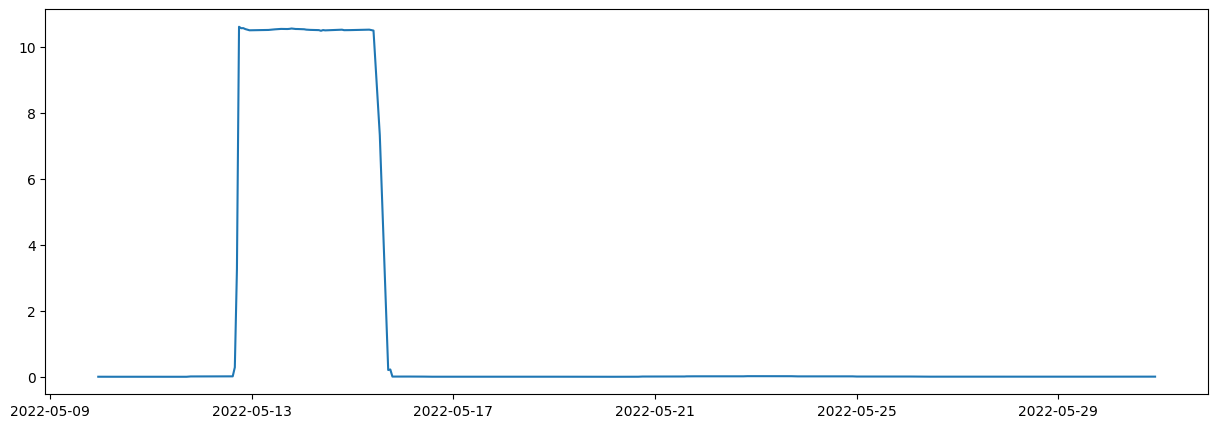

In [82]:
import matplotlib.pyplot as plt
import pandas as pd, numpy as np

# tf_loss = np.load('vae_model_origine/loss_test_data.npy')
tf_loss = np.load('final2/loss_test_data.npy')
# tf_loss = np.nan_to_num(tf_loss)  # 将 NaN 转换为 0
window_loss = np.mean(tf_loss, axis=1)
# window_loss = np.log(window_loss + 1e-10)  # 加一个小的常数以避免对
     
data = pd.read_csv('./final2/data.csv')
data['Hour'] = pd.to_datetime(data['Hour'])

# 获取时间列作为索引
x = data['Hour'].dt.to_pydatetime().tolist()
x = x[6648:6648+218]
plt.figure(figsize=(15,5))
plt.plot(x, window_loss)
plt.show()

+ ### Calculate aggregated & averaged transformer loss per each day

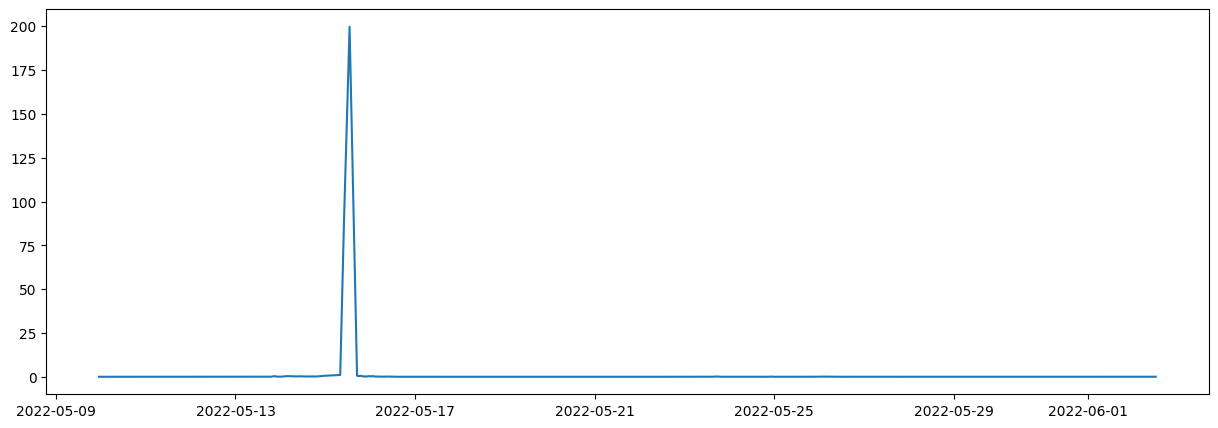

In [83]:
def aggregate_tf_loss_from_sliding_windows(data):

    l = data.shape[1]
    n = data.shape[0]
    ano = np.zeros((n, l+n-1))
    count = np.zeros(l+n-1)

    for i in range(0, n):
        for j in range(0, l):
            ano[i, i+j] = data[i, j]
            count[i + j] += 1

    agg_loss = np.sum(ano, axis=0) / count
    return agg_loss

tf_loss_day = aggregate_tf_loss_from_sliding_windows(tf_loss)
np.save('transformer_loss.npy', tf_loss_day)

data = pd.read_csv('./final2/data.csv')
data['Hour'] = pd.to_datetime(data['Hour'])

# 获取时间列作为索引
x = data['Hour'].dt.to_pydatetime().tolist()
x = x[6648:6648+245]
# tf_loss_day = np.log     (tf_loss_day + 1e-10)  # 加一个小的常数以避免对
df1 = pd.DataFrame({'loss' : tf_loss_day}, index=x)

plt.figure(figsize=(15,5))
plt.plot(x, tf_loss_day)
#plt.show()
plt.savefig('transformer_loss')

+ ### Reconstruc hourly data from tf decoding output by VAE decoding

In [87]:
# tf_recon = np.load('vae_model_origine/tf_output.npy')
tf_recon = np.load('final2/tf_output.npy')
print(tf_recon.shape)

tf_recon = np.reshape(tf_recon, (-1, 64))
print(tf_recon.shape)
vae_recon = model.decoder(tf_recon)
print(vae_recon.shape)  
vae_recon = vae_recon.numpy()
# vae_recon = np.reshape(vae_recon, (-1, 245, 24, 10))
vae_recon = np.reshape(vae_recon, (-1, 28, 24, 5))
print(vae_recon.shape)
# desired_shape = (1, 110, 4)
# total_elements = np.prod(desired_shape)
# 
# # 获取当前的元素总数
# current_elements = vae_recon.size
# 
# if current_elements >= total_elements:
#     # 切片以保留我们需要的数据
#     vae_recon = vae_recon.flatten()[:total_elements]  # 保留所需的元素
#     vae_recon = vae_recon.reshape((-1, *desired_sh ape))  # 重新塑形
# else:
#     raise ValueError("当前数据元素数量不足以填满目标形状")
# 
# print(vae_recon.shape)  # 验证新形状

(218, 28, 64)
(6104, 64)
(6104, 24, 5)
(218, 28, 24, 5)


+ ### Compute anomaly score per each hour

28
218


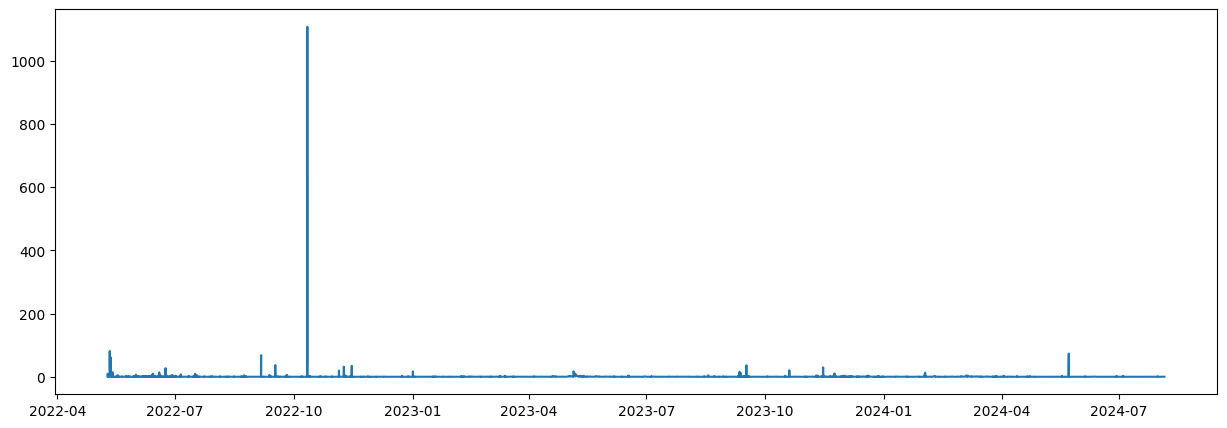

In [88]:
def aggregate_anomaly_score_from_sliding_windows(orig, target):
    l = target.shape[1]
    print(l)
    n = target.shape[0]
    print(n)
    ano = np.zeros((n, l+n-1, 24))
    # print(ano.shape)
    count = np.zeros((l+n-1))

    for i in range(0, n):
        for j in range(0, l):
            for k in range(0, 24):
                # print(i, j, k)
                diff = np.subtract(target[i, j, k], orig[(i+j)*24 + k])
                diff = np.square(diff).mean()
                ano[i, i+j, k] = diff
            count[i + j] += 1

    agg = np.sum(ano, axis=0)
    score = np.zeros((n+l-1, 24))
    for i in range(0, n+l-1):
        for j in range(0, 24):
            score[i, j] = agg[i, j] / count[i]
    return score.reshape(-1)

anomaly_score = aggregate_anomaly_score_from_sliding_windows(orig, vae_recon)
np.save('anomaly_score', anomaly_score)

data = pd.read_csv('./final2/data.csv')
data['Hour'] = pd.to_datetime(data['Hour'])

# 获取时间列作为索引
x = data['Hour'].dt.to_pydatetime().tolist()
x = x[6648:6648+5880]
plt.figure(figsize=(15,5))
plt.plot(x, anomaly_score)
#plt.show()
plt.savefig('anomaly_score')
